In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
pd.__version__

'1.5.3'

In [3]:
car_price = pd.read_csv(r'C:/Users/pc/Documents/car_price.csv')

In [4]:
features = ['MSRP',
            'Make',
            'Model',
            'Year',
            'Engine HP',
            'Engine Cylinders',
            'Transmission Type',
            'Vehicle Style',
            'highway MPG',
            'city mpg']

In [5]:
car_price[features] = car_price[features].astype('string')
for f in features:
    car_price[f] = car_price[f].str.replace(' ', '_').str.lower()

In [6]:
car_price_f = car_price[features]

In [7]:
nulls_rows = car_price_f.isnull().any(axis=1)

In [8]:
car_price_f[nulls_rows] = car_price_f[nulls_rows].fillna('0')

C:\Users\pc\AppData\Local\Temp\ipykernel_7596\2057292027.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_price_f[nulls_rows] = car_price_f[nulls_rows].fillna('0')


In [9]:
car_price_f = car_price_f.rename(str.lower, axis='columns').rename(columns={'msrp' : 'price'})

In [10]:
numerical_features = ['price', 'year', 'engine hp', 'engine cylinders','highway mpg', 'city mpg']

In [11]:
car_price_f[numerical_features] = car_price_f[numerical_features].astype(float)

In [12]:
categorical_features = car_price_f.select_dtypes('string').astype('category').columns

In [13]:
m = car_price_f.price.mean()

car_price_f['above_average'] = (car_price_f['price'] >= m).astype(int)

In [14]:
from sklearn.model_selection import train_test_split

X = car_price_f.drop(columns=['above_average','price']).copy()
y = car_price_f['above_average']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, train_size=0.6, random_state=1)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

In [15]:
from sklearn.model_selection import train_test_split

X = car_price_f.drop(columns=['above_average','price']).copy()
y = car_price_f['above_average']

#X_train_full, X_test, y_train_full, y_test  = train_test_split(X , y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val  = train_test_split(X_train_full, y_train_full , test_size=0.25, random_state=1)


df_full_train, df_test = train_test_split(car_price_f, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [16]:
#Q1

In [17]:
from sklearn.metrics import roc_auc_score

auc_scores = {}
for var in X_train.select_dtypes('number'):
    score = roc_auc_score(car_price_f.above_average, car_price_f[var])
    print("score",var ,score)
    if score < 0.5:
        score = roc_auc_score(car_price_f.above_average, -car_price_f[var])
        print("inf",var, score)
    auc_scores[var] = score
best_variable = max(auc_scores, key=auc_scores.get)

print("La variable numérique avec le plus haut AUC est :", best_variable)
print("Son AUC est :", auc_scores[best_variable])

score year 0.6918066573828033
score engine hp 0.9157738865600598
score engine cylinders 0.765740332665676
score highway mpg 0.3692506025635423
inf highway mpg 0.6307493974364577
score city mpg 0.3293212028589015
inf city mpg 0.6706787971410986
La variable numérique avec le plus haut AUC est : engine hp
Son AUC est : 0.9157738865600598


In [18]:
auc_scores

{'year': 0.6918066573828033,
 'engine hp': 0.9157738865600598,
 'engine cylinders': 0.765740332665676,
 'highway mpg': 0.6307493974364577,
 'city mpg': 0.6706787971410986}

In [19]:
# engine hp

In [20]:
#Q2

In [22]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
train_dict = X_train.to_dict(orient='records')
dv_fit = dv.fit(train_dict)

In [23]:
Xtrain_ohe = dv_fit.transform(train_dict)
Xtrain_ohe = pd.DataFrame(Xtrain_ohe, columns=dv_fit.get_feature_names_out())

In [24]:
Xval_ohe = dv_fit.transform(X_val.to_dict(orient='records'))
Xval_ohe = pd.DataFrame(Xval_ohe, columns=dv_fit.get_feature_names_out())

In [25]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(Xtrain_ohe, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [26]:
#y_pred = pd.Series(model.predict_proba(Xval_ohe)[:,1])
y_pred = model.predict_proba(Xval_ohe)[:,1]
#y_pred = pd.Series(model.predict(Xval_ohe))

In [27]:
#roc_auc_score(y_val, y_pred)
print(f'AUC on the validation dataset: {roc_auc_score(y_val, y_pred):.3f}')


AUC on the validation dataset: 0.980


In [28]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [29]:
df_scores = tpr_fpr_dataframe(y_val, y_pred)

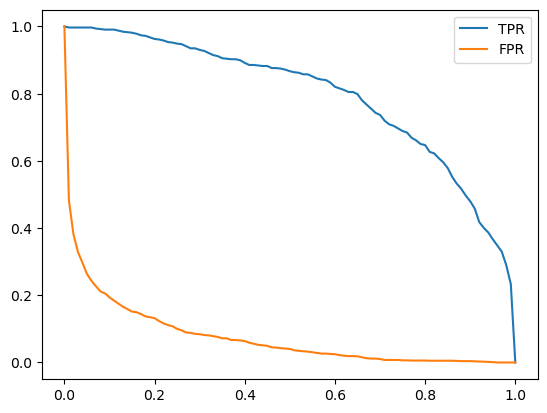

In [30]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

In [31]:
from sklearn.metrics import auc
auc(df_scores.fpr, df_scores.tpr)

0.9803827994246515

In [ ]:
#0.9803827994246515

In [33]:
#Q3

In [34]:
def precision_recall_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

    return df_scores


df_scores_recall = precision_recall_dataframe(y_val, y_pred)
df_scores_recall

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,646,1737,0,0,0.271087,1.000000
1,0.01,644,838,2,899,0.434548,0.996904
2,0.02,644,664,2,1073,0.492355,0.996904
3,0.03,644,572,2,1165,0.529605,0.996904
4,0.04,644,516,2,1221,0.555172,0.996904
...,...,...,...,...,...,...,...
96,0.96,225,0,421,1737,1.000000,0.348297
97,0.97,213,0,433,1737,1.000000,0.329721
98,0.98,187,0,459,1737,1.000000,0.289474
99,0.99,151,0,495,1737,1.000000,0.233746


In [35]:
df_scores_recall[df_scores_recall['precision'].round(2) == df_scores_recall['recall'].round(2)]['threshold']

46    0.46
47    0.47
Name: threshold, dtype: float64

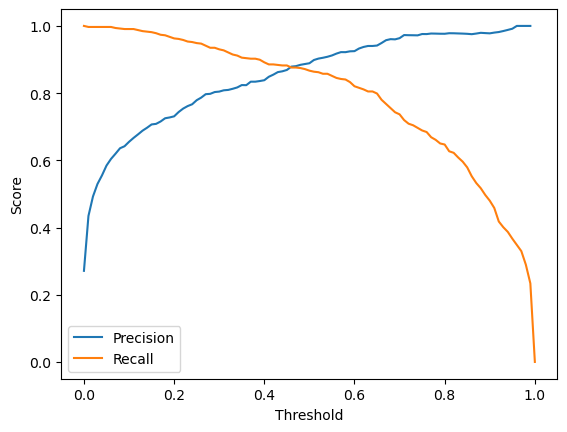

In [36]:
plt.plot(df_scores_recall.threshold, df_scores_recall['precision'], label='Precision')
plt.plot(df_scores_recall.threshold, df_scores_recall['recall'], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

In [ ]:
# 46    0.46
# 47    0.47

In [37]:
#Q4  = F1 score = 2 * P * R / (P + R)

In [38]:
df_scores_recall['F1_score'] = 2 * (df_scores_recall.precision * df_scores_recall.recall) / (df_scores_recall.precision + df_scores_recall.recall)

In [39]:
df_scores_recall[df_scores_recall['F1_score'] == df_scores_recall['F1_score'].max()]

,threshold,tp,fp,fn,tn,precision,recall,F1_score
54,0.54,554,56,92,1681,0.908197,0.857585,0.882166


In [40]:
thresholds_to_test = [0.12, 0.32, 0.52, 0.72]

for t in thresholds_to_test:
    f1_scores = df_scores_recall[df_scores_recall["threshold"] == t]["F1_score"].values
    print(f"thresholds : {t} ; f1: {f1_scores}")

thresholds : 0.12 ; f1: [0.80352645]
thresholds : 0.32 ; f1: [0.86169442]
thresholds : 0.52 ; f1: [0.88202692]
thresholds : 0.72 ; f1: [0.82005372]


In [ ]:
# thresholds : 0.52 ; f1: [0.88202692]

In [41]:
#Q5

In [42]:
dv = DictVectorizer(sparse=False)
train_dict = df_full_train.to_dict(orient='records')
dv_fit_2 = dv.fit(train_dict)

df_full_train_ohe = dv_fit_2.transform(train_dict)
df_full_train_ohe = pd.DataFrame(df_full_train_ohe, columns=dv_fit_2.get_feature_names_out())

In [43]:
df_full_train_ohe

,above_average,city mpg,engine cylinders,engine hp,highway mpg,make=acura,make=alfa_romeo,make=aston_martin,make=audi,make=bentley,...,vehicle style=convertible_suv,vehicle style=coupe,vehicle style=crew_cab_pickup,vehicle style=extended_cab_pickup,vehicle style=passenger_minivan,vehicle style=passenger_van,vehicle style=regular_cab_pickup,vehicle style=sedan,vehicle style=wagon,year
0,1.0,15.0,8.0,382.0,22.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007.0
1,0.0,18.0,6.0,332.0,26.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016.0
2,0.0,18.0,6.0,285.0,24.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2017.0
3,1.0,19.0,6.0,350.0,26.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016.0
4,0.0,21.0,4.0,200.0,31.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9526,1.0,18.0,6.0,272.0,26.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016.0
9527,1.0,13.0,8.0,381.0,17.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0
9528,0.0,18.0,4.0,150.0,26.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1997.0
9529,0.0,22.0,4.0,164.0,33.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009.0


In [44]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for train_index, val_index in kf.split(df_full_train_ohe):
    
    X_train, X_val = df_full_train_ohe.iloc[train_index].drop(columns=['above_average','price']), df_full_train_ohe.iloc[val_index].drop(columns=['above_average','price'])
    y_train, y_val = df_full_train_ohe.iloc[train_index]['above_average'], df_full_train_ohe.iloc[val_index]['above_average']
    
    model_reg_kf = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    
    model_reg_kf.fit(X_train, y_train)
    
    y_val_pred = model_reg_kf.predict_proba(X_val)[:, 1]
    
    auc_score = roc_auc_score(y_val, y_val_pred)
    
    print(auc_score)
    
    auc_scores.append(auc_score)

print("Std auc_scores :", np.std(auc_scores))

0.9784898110716937
0.9774885099177553
0.9830614578104959
0.9772753889911328
0.9776889776889778
Std auc_scores : 0.002169564562056365


In [45]:
#Q6

In [46]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

mean_scores = []

for train_index, val_index in kf.split(df_full_train_ohe):
    
    X_train, X_val = df_full_train_ohe.iloc[train_index].drop(columns=['above_average','price']), df_full_train_ohe.iloc[val_index].drop(columns=['above_average','price'])
    y_train, y_val = df_full_train_ohe.iloc[train_index]['above_average'], df_full_train_ohe.iloc[val_index]['above_average']
    
    for c in [0.01, 0.1, 0.5, 10]:
    
        model_reg_kf = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        
        model_reg_kf.fit(X_train, y_train)
        
        y_val_pred = model_reg_kf.predict_proba(X_val)[:, 1]
        
        auc_score = roc_auc_score(y_val, y_val_pred)
        
    print(auc_score)
    
    auc_scores.append(auc_score)

print("Std auc_scores :", np.std(auc_scores))

0.9817754310700437
0.9805740643004794
0.9848000669232055
0.9798867882438236
0.9890415140415141
Std auc_scores : 0.0035894923649973805


In [47]:
#0.9817754310700437

In [48]:
scores_c = []

for c in [0.01, 0.1, 0.5, 10]:
    
    mean_scores = []
    
    for train_index, val_index in kf.split(df_full_train_ohe):
    
        X_train, X_val = df_full_train_ohe.iloc[train_index].drop(columns=['above_average','price']), df_full_train_ohe.iloc[val_index].drop(columns=['above_average','price'])
        y_train, y_val = df_full_train_ohe.iloc[train_index]['above_average'], df_full_train_ohe.iloc[val_index]['above_average']
        
        model_reg_kf = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        
        model_reg_kf.fit(X_train, y_train)
        
        y_val_pred = model_reg_kf.predict_proba(X_val)[:, 1]
        
        mean_score = roc_auc_score(y_val, y_val_pred)
        print(mean_score)
    
        mean_scores.append(mean_score)
    
    scores_c.append(np.array(mean_scores).mean())
        
    print(f'C : {c} , score moyen :  {np.array(mean_scores).mean()} ')
    
print(f'C : {c} , score moyen :  {np.array(mean_scores).mean()} ')

0.9555619723345158
0.948513161366935
0.9504336066030897
0.9531844292008254
0.9502400377400377
C : 0.01 , score moyen :  0.9515866414490807 
0.9704651706404861
0.9700584399876853
0.9740031230829289
0.9710891751714907
0.9733821733821734
C : 0.1 , score moyen :  0.9717996164529529 
0.9745400544509528
0.977029456392664
0.98294991913446
0.9777285148625285
0.9777125652125652
C : 0.5 , score moyen :  0.9779921020106341 
0.9817754310700437
0.9805740643004794
0.9848000669232055
0.9798867882438236
0.9890415140415141
C : 10 , score moyen :  0.9832155729158132 
C : 10 , score moyen :  0.9832155729158132 


In [49]:
#C : 10 , score moyen :  0.9832155729158132 